In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm
import yfinance as yf
import alphalens as al

from prices import read_stock_prices
from plotter import plot

%load_ext autoreload
%autoreload 2

In [2]:
vader_df = pd.concat([pd.read_csv('sentiments/stocks_vader_mean_sentiment.csv'), 
                     pd.read_csv('sentiments/memestocks_vader_mean_sentiment.csv')])
vader_df

,Date,Stock,Sentiment
0,2021-01-01,AAPL,0.212245
1,2021-01-01,PLTR,0.230110
2,2021-01-01,TSLA,0.206411
3,2021-01-02,AAPL,0.180537
4,2021-01-02,PLTR,0.153601
...,...,...,...
355,2021-04-29,GME,0.154687
356,2021-04-29,NOK,0.234900
357,2021-04-30,AMC,0.169916
358,2021-04-30,GME,0.132105


In [3]:
roberta_df = pd.concat([pd.read_csv("sentiments/roberta-sentiment2.csv", index_col=0), 
                        pd.read_csv("sentiments/roberta-sentiment-meme.csv", index_col=0),
                        pd.read_csv("sentiments/roberta-sentiment-fang.csv", index_col=0)])
roberta_df

,Date,Stock,Sentiment
0,2021-01-01,AAPL,0.335990
1,2021-01-01,PLTR,0.257533
2,2021-01-01,TSLA,0.210278
3,2021-01-02,AAPL,0.220163
4,2021-01-02,PLTR,0.186481
...,...,...,...
475,2021-04-26,GOOG,0.270178
476,2021-04-27,GOOG,0.333182
477,2021-04-28,GOOG,0.286896
478,2021-04-29,GOOG,0.238004


## Prices

In [4]:
stocks = ["FB", "AAPL", "AMZN", "NFLX", "GOOG", "PLTR", "NOK", "AMC", "GME", "TSLA"]
#stocks = ["FB", "AAPL", "AMZN", "NFLX", "GOOG", "PLTR", "TSLA"]
price_data = read_stock_prices(stocks)
price_data

,index,Date,Stock,Close
0,0,2021-01-04,FB,268.940002
1,1,2021-01-05,FB,270.970001
2,2,2021-01-06,FB,263.309998
3,3,2021-01-07,FB,268.739990
4,4,2021-01-08,FB,267.570007
...,...,...,...,...
965,92,2021-05-17,TSLA,576.830017
966,93,2021-05-18,TSLA,577.869995
967,94,2021-05-19,TSLA,563.460022
968,95,2021-05-20,TSLA,586.780029


In [5]:
vader_df['Date'] = vader_df['Date'].astype('datetime64[ns]')

vader_df = pd.merge(vader_df, price_data,  how='left', on = ['Date','Stock'])
vader_df.dropna(inplace = True)
vader_df

,Date,Stock,Sentiment,index,Close
9,2021-01-04,AAPL,0.144920,0.0,128.997803
10,2021-01-04,PLTR,0.151369,0.0,23.370001
11,2021-01-04,TSLA,0.175727,0.0,729.770020
12,2021-01-05,AAPL,0.166037,1.0,130.592697
13,2021-01-05,PLTR,0.196005,1.0,24.600000
...,...,...,...,...,...
715,2021-04-29,GME,0.154687,80.0,176.190002
716,2021-04-29,NOK,0.234900,80.0,4.670000
717,2021-04-30,AMC,0.169916,81.0,10.030000
718,2021-04-30,GME,0.132105,81.0,173.589996


In [6]:
roberta_df['Date'] = roberta_df['Date'].astype('datetime64[ns]')

roberta_df = pd.merge(roberta_df, price_data,  how='left', on = ['Date','Stock'])
roberta_df.dropna(inplace = True)
roberta_df

,Date,Stock,Sentiment,index,Close
9,2021-01-04,AAPL,0.185867,0.0,128.997803
10,2021-01-04,PLTR,0.199053,0.0,23.370001
11,2021-01-04,TSLA,0.266390,0.0,729.770020
12,2021-01-05,AAPL,0.255921,1.0,130.592697
13,2021-01-05,PLTR,0.230094,1.0,24.600000
...,...,...,...,...,...
1195,2021-04-26,GOOG,0.270178,77.0,2326.739990
1196,2021-04-27,GOOG,0.333182,78.0,2307.120117
1197,2021-04-28,GOOG,0.286896,79.0,2379.909912
1198,2021-04-29,GOOG,0.238004,80.0,2429.889893


Correlation: 0.02


/home/romet/Projects/ut/nlp/project/flash-boys/plotter.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NormPrice'] = price


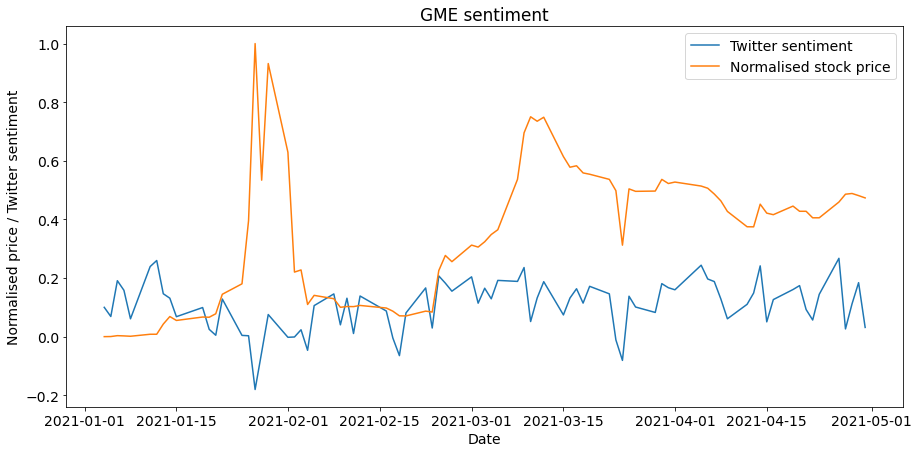

In [18]:
plot(roberta_df, "GME")

## Alphalens

In [8]:
vader_sentiment = vader_df.pivot(index='Date', columns='Stock', values='Sentiment')
roberta_sentiment = roberta_df.pivot(index='Date', columns='Stock', values='Sentiment')
prices = price_data.pivot(index='Date', columns='Stock', values='Close')

In [9]:
vader_data = al.utils.get_clean_factor_and_forward_returns(vader_sentiment.stack(), prices, quantiles=5, bins=None, periods=[1])
roberta_data = al.utils.get_clean_factor_and_forward_returns(roberta_sentiment.stack(), prices, quantiles=5, bins=None, periods=[1])

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [10]:
vader_data = vader_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in vader_data.index.values],
        names=['date', 'asset']))
roberta_data = roberta_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in roberta_data.index.values],
        names=['date', 'asset']))

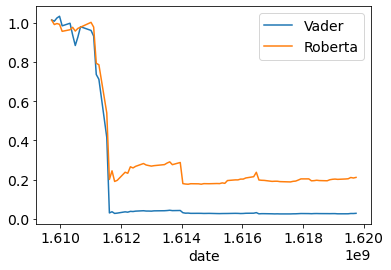

In [11]:
vader_factor_returns = al.performance.factor_returns(vader_data).iloc[:, 0]
roberta_factor_returns = al.performance.factor_returns(roberta_data).iloc[:, 0]
(1 + vader_factor_returns).cumprod().plot()
(1 + roberta_factor_returns).cumprod().plot()
plt.legend(["Vader", "Roberta"])

In [12]:
# qr_factor_returns = al.performance.mean_return_by_quantile(unix_factor_data)[0].iloc[:, 0]

# (10000*qr_factor_returns).plot.bar(
#     subplots=True,
#     sharey=True,
#     layout=(5,3),
#     figsize=(14, 14),
#     legend=False)

In [13]:
# ls_FRA = al.performance.factor_rank_autocorrelation(unix_factor_data)
# ls_FRA.plot(title="Factor Rank Autocorrelation")

In [14]:
# daily_annualization_factor = np.sqrt(252)

# (daily_annualization_factor * factor_returns.mean() / factor_returns.std()).round(2)